# Phase 5: Machine Learning Models - Churn Prediction

## Objectives:
- Build churn prediction models using multiple algorithms
- Compare model performance (Logistic Regression, Random Forest, XGBoost, LightGBM)
- Evaluate using multiple metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
- Feature importance analysis
- Model optimization and hyperparameter tuning
- Save best model for deployment

## Dataset:
- Source: `data/processed/scaled_ml_data.csv`
- Features: 44 (scaled and encoded)
- Target: Churn Risk (Low/Medium/High)
- Records: 350 customers

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported successfully!")
print(f"Random State: {RANDOM_STATE}")

✅ Libraries imported successfully!
Random State: 42


In [2]:
# Load the featured dataset (has churn_risk column)
df_featured = pd.read_csv('../data/processed/featured_customer_data.csv')

print(f"Featured Dataset Shape: {df_featured.shape}")
print(f"\nColumns ({len(df_featured.columns)}):")
print(df_featured.columns.tolist())
print(f"\nFirst 3 rows:")
df_featured.head(3)

Featured Dataset Shape: (350, 28)

Columns (28):
['customer_id', 'gender', 'age', 'city', 'membership_type', 'total_spend', 'items_purchased', 'average_rating', 'discount_applied', 'days_since_last_purchase', 'satisfaction_level', 'clv', 'aov', 'purchase_frequency', 'recency_score', 'frequency_score', 'monetary_score', 'rfm_score', 'rfm_value', 'rfm_segment', 'age_group', 'spending_category', 'norm_frequency', 'norm_rating', 'norm_recency', 'engagement_score', 'discount_user', 'churn_risk']

First 3 rows:


,customer_id,gender,age,city,membership_type,total_spend,items_purchased,average_rating,discount_applied,days_since_last_purchase,...,rfm_value,rfm_segment,age_group,spending_category,norm_frequency,norm_rating,norm_recency,engagement_score,discount_user,churn_risk
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,...,11,Loyal,Young (< 30),High Spender,0.500000,0.842105,0.703704,66.374269,1,Low Risk
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,...,9,Potential Loyalist,Early 30s (30-34),High Spender,0.285714,0.578947,0.833333,53.796992,0,Low Risk
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,...,4,Hibernating,Mature (40+),Medium Spender,0.142857,0.210526,0.388889,23.696742,1,High Risk


## 2. Target Variable Preparation

🎯 Target Variable (churn_risk) Distribution:

churn_risk
Low Risk       226
Medium Risk     69
High Risk       55
Name: count, dtype: int64

Percentage Distribution:
churn_risk
Low Risk       64.571429
Medium Risk    19.714286
High Risk      15.714286
Name: proportion, dtype: float64


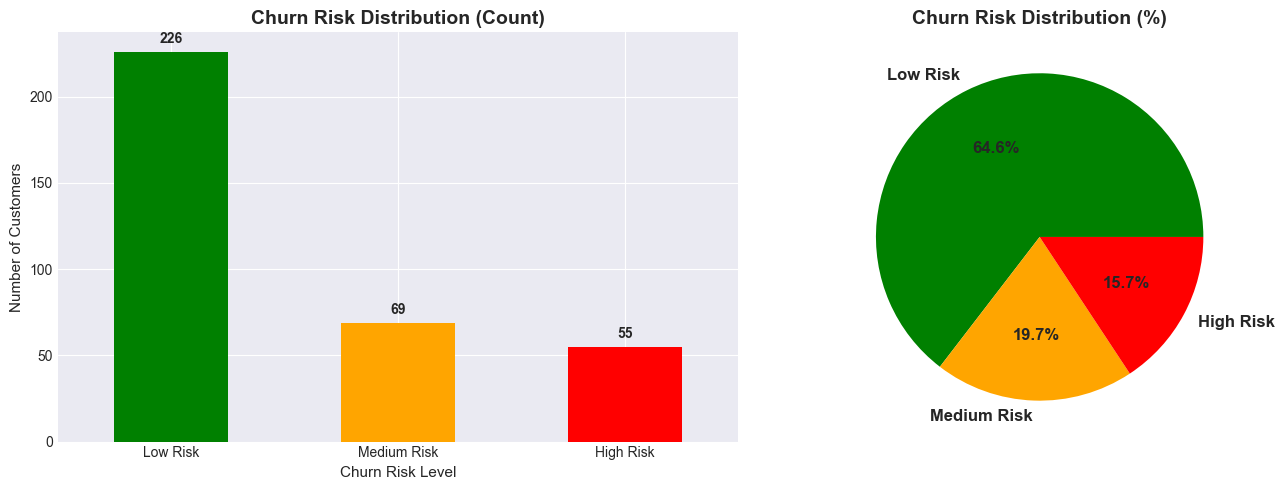


✅ Target distribution visualization saved


In [3]:
# Check target variable distribution
print("🎯 Target Variable (churn_risk) Distribution:\n")
print(df_featured['churn_risk'].value_counts())
print(f"\nPercentage Distribution:")
print(df_featured['churn_risk'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
ax1 = axes[0]
churn_counts = df_featured['churn_risk'].value_counts()
churn_counts.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'])
ax1.set_title('Churn Risk Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Churn Risk Level', fontsize=11)
ax1.set_ylabel('Number of Customers', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
for i, v in enumerate(churn_counts.values):
    ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')

# Pie chart
ax2 = axes[1]
churn_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                  colors=['green', 'orange', 'red'],
                  textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Churn Risk Distribution (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('../visualizations/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Target distribution visualization saved")

In [4]:
# Convert churn_risk to binary classification (High risk vs Low/Medium risk)
# This makes the problem more manageable and focused on identifying high-risk customers
df_featured['churn_binary'] = df_featured['churn_risk'].apply(lambda x: 1 if x == 'High Risk' else 0)

print("🎯 Binary Churn Target Distribution:\n")
print(f"Not High Risk (0): {(df_featured['churn_binary'] == 0).sum()} ({(df_featured['churn_binary'] == 0).sum() / len(df_featured) * 100:.1f}%)")
print(f"High Risk (1): {(df_featured['churn_binary'] == 1).sum()} ({(df_featured['churn_binary'] == 1).sum() / len(df_featured) * 100:.1f}%)")
print(f"\nClass Imbalance Ratio: {(df_featured['churn_binary'] == 0).sum() / (df_featured['churn_binary'] == 1).sum():.2f}:1")

🎯 Binary Churn Target Distribution:

Not High Risk (0): 295 (84.3%)
High Risk (1): 55 (15.7%)

Class Imbalance Ratio: 5.36:1


## 3. Feature Selection and Train-Test Split

In [5]:
# Define features (X) and target (y)
# Exclude ID columns, target columns, and categorical string columns
exclude_cols = ['customer_id', 'gender', 'city', 'membership_type', 'satisfaction_level', 
                'rfm_segment', 'age_group', 'spending_category', 'churn_risk', 'churn_binary']
feature_cols = [col for col in df_featured.columns if col not in exclude_cols]

X = df_featured[feature_cols]
y = df_featured['churn_binary']

print(f"📊 Feature Matrix Shape: {X.shape}")
print(f"🎯 Target Vector Shape: {y.shape}")
print(f"\n📋 Number of Features: {len(feature_cols)}")
print(f"\nFeature Columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

📊 Feature Matrix Shape: (350, 19)
🎯 Target Vector Shape: (350,)

📋 Number of Features: 19

Feature Columns:
  1. age
  2. total_spend
  3. items_purchased
  4. average_rating
  5. discount_applied
  6. days_since_last_purchase
  7. clv
  8. aov
  9. purchase_frequency
  10. recency_score
  11. frequency_score
  12. monetary_score
  13. rfm_score
  14. rfm_value
  15. norm_frequency
  16. norm_rating
  17. norm_recency
  18. engagement_score
  19. discount_user


In [6]:
# Split data into train, validation, and test sets
# 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=RANDOM_STATE, stratify=y_temp  # 0.1765 * 0.85 ≈ 0.15
)

print("📊 Data Split Summary:")
print("=" * 60)
print(f"Training Set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(df_featured)*100:.1f}%)")
print(f"  - High Risk: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"  - Low/Med Risk: {len(y_train) - y_train.sum()} ({(len(y_train) - y_train.sum())/len(y_train)*100:.1f}%)")

print(f"\nValidation Set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df_featured)*100:.1f}%)")
print(f"  - High Risk: {y_val.sum()} ({y_val.sum()/len(y_val)*100:.1f}%)")
print(f"  - Low/Med Risk: {len(y_val) - y_val.sum()} ({(len(y_val) - y_val.sum())/len(y_val)*100:.1f}%)")

print(f"\nTest Set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(df_featured)*100:.1f}%)")
print(f"  - High Risk: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")
print(f"  - Low/Med Risk: {len(y_test) - y_test.sum()} ({(len(y_test) - y_test.sum())/len(y_test)*100:.1f}%)")
print("=" * 60)

📊 Data Split Summary:
Training Set:   244 samples (69.7%)
  - High Risk: 39 (16.0%)
  - Low/Med Risk: 205 (84.0%)

Validation Set: 53 samples (15.1%)
  - High Risk: 8 (15.1%)
  - Low/Med Risk: 45 (84.9%)

Test Set:       53 samples (15.1%)
  - High Risk: 8 (15.1%)
  - Low/Med Risk: 45 (84.9%)


## 4. Model Training and Evaluation
### 4.1 Baseline Model - Logistic Regression

In [7]:
# Train Logistic Regression model
print("🚀 Training Logistic Regression Model...\n")

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Prediction probabilities for ROC-AUC
y_train_proba_lr = lr_model.predict_proba(X_train)[:, 1]
y_val_proba_lr = lr_model.predict_proba(X_val)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
lr_metrics = {
    'Model': 'Logistic Regression',
    'Train_Accuracy': accuracy_score(y_train, y_train_pred_lr),
    'Val_Accuracy': accuracy_score(y_val, y_val_pred_lr),
    'Test_Accuracy': accuracy_score(y_test, y_test_pred_lr),
    'Train_Precision': precision_score(y_train, y_train_pred_lr),
    'Val_Precision': precision_score(y_val, y_val_pred_lr),
    'Test_Precision': precision_score(y_test, y_test_pred_lr),
    'Train_Recall': recall_score(y_train, y_train_pred_lr),
    'Val_Recall': recall_score(y_val, y_val_pred_lr),
    'Test_Recall': recall_score(y_test, y_test_pred_lr),
    'Train_F1': f1_score(y_train, y_train_pred_lr),
    'Val_F1': f1_score(y_val, y_val_pred_lr),
    'Test_F1': f1_score(y_test, y_test_pred_lr),
    'Train_ROC_AUC': roc_auc_score(y_train, y_train_proba_lr),
    'Val_ROC_AUC': roc_auc_score(y_val, y_val_proba_lr),
    'Test_ROC_AUC': roc_auc_score(y_test, y_test_proba_lr)
}

print("✅ Logistic Regression - Performance Metrics:")
print("=" * 60)
print(f"Train Accuracy:  {lr_metrics['Train_Accuracy']:.4f}")
print(f"Val Accuracy:    {lr_metrics['Val_Accuracy']:.4f}")
print(f"Test Accuracy:   {lr_metrics['Test_Accuracy']:.4f}")
print(f"\nTest Precision:  {lr_metrics['Test_Precision']:.4f}")
print(f"Test Recall:     {lr_metrics['Test_Recall']:.4f}")
print(f"Test F1-Score:   {lr_metrics['Test_F1']:.4f}")
print(f"Test ROC-AUC:    {lr_metrics['Test_ROC_AUC']:.4f}")
print("=" * 60)

🚀 Training Logistic Regression Model...

✅ Logistic Regression - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    0.9811
Test Accuracy:   0.9811

Test Precision:  0.8889
Test Recall:     1.0000
Test F1-Score:   0.9412
Test ROC-AUC:    1.0000


### 4.2 Random Forest Classifier

In [8]:
# Train Random Forest model
print("🌲 Training Random Forest Model...\n")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Prediction probabilities
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_metrics = {
    'Model': 'Random Forest',
    'Train_Accuracy': accuracy_score(y_train, y_train_pred_rf),
    'Val_Accuracy': accuracy_score(y_val, y_val_pred_rf),
    'Test_Accuracy': accuracy_score(y_test, y_test_pred_rf),
    'Train_Precision': precision_score(y_train, y_train_pred_rf),
    'Val_Precision': precision_score(y_val, y_val_pred_rf),
    'Test_Precision': precision_score(y_test, y_test_pred_rf),
    'Train_Recall': recall_score(y_train, y_train_pred_rf),
    'Val_Recall': recall_score(y_val, y_val_pred_rf),
    'Test_Recall': recall_score(y_test, y_test_pred_rf),
    'Train_F1': f1_score(y_train, y_train_pred_rf),
    'Val_F1': f1_score(y_val, y_val_pred_rf),
    'Test_F1': f1_score(y_test, y_test_pred_rf),
    'Train_ROC_AUC': roc_auc_score(y_train, y_train_proba_rf),
    'Val_ROC_AUC': roc_auc_score(y_val, y_val_proba_rf),
    'Test_ROC_AUC': roc_auc_score(y_test, y_test_proba_rf)
}

print("✅ Random Forest - Performance Metrics:")
print("=" * 60)
print(f"Train Accuracy:  {rf_metrics['Train_Accuracy']:.4f}")
print(f"Val Accuracy:    {rf_metrics['Val_Accuracy']:.4f}")
print(f"Test Accuracy:   {rf_metrics['Test_Accuracy']:.4f}")
print(f"\nTest Precision:  {rf_metrics['Test_Precision']:.4f}")
print(f"Test Recall:     {rf_metrics['Test_Recall']:.4f}")
print(f"Test F1-Score:   {rf_metrics['Test_F1']:.4f}")
print(f"Test ROC-AUC:    {rf_metrics['Test_ROC_AUC']:.4f}")
print("=" * 60)

🌲 Training Random Forest Model...

✅ Random Forest - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    1.0000
Test Accuracy:   1.0000

Test Precision:  1.0000
Test Recall:     1.0000
Test F1-Score:   1.0000
Test ROC-AUC:    1.0000
✅ Random Forest - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    1.0000
Test Accuracy:   1.0000

Test Precision:  1.0000
Test Recall:     1.0000
Test F1-Score:   1.0000
Test ROC-AUC:    1.0000


### 4.3 XGBoost Classifier

In [9]:
# Train XGBoost model
print("⚡ Training XGBoost Model...\n")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# Prediction probabilities
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
xgb_metrics = {
    'Model': 'XGBoost',
    'Train_Accuracy': accuracy_score(y_train, y_train_pred_xgb),
    'Val_Accuracy': accuracy_score(y_val, y_val_pred_xgb),
    'Test_Accuracy': accuracy_score(y_test, y_test_pred_xgb),
    'Train_Precision': precision_score(y_train, y_train_pred_xgb),
    'Val_Precision': precision_score(y_val, y_val_pred_xgb),
    'Test_Precision': precision_score(y_test, y_test_pred_xgb),
    'Train_Recall': recall_score(y_train, y_train_pred_xgb),
    'Val_Recall': recall_score(y_val, y_val_pred_xgb),
    'Test_Recall': recall_score(y_test, y_test_pred_xgb),
    'Train_F1': f1_score(y_train, y_train_pred_xgb),
    'Val_F1': f1_score(y_val, y_val_pred_xgb),
    'Test_F1': f1_score(y_test, y_test_pred_xgb),
    'Train_ROC_AUC': roc_auc_score(y_train, y_train_proba_xgb),
    'Val_ROC_AUC': roc_auc_score(y_val, y_val_proba_xgb),
    'Test_ROC_AUC': roc_auc_score(y_test, y_test_proba_xgb)
}

print("✅ XGBoost - Performance Metrics:")
print("=" * 60)
print(f"Train Accuracy:  {xgb_metrics['Train_Accuracy']:.4f}")
print(f"Val Accuracy:    {xgb_metrics['Val_Accuracy']:.4f}")
print(f"Test Accuracy:   {xgb_metrics['Test_Accuracy']:.4f}")
print(f"\nTest Precision:  {xgb_metrics['Test_Precision']:.4f}")
print(f"Test Recall:     {xgb_metrics['Test_Recall']:.4f}")
print(f"Test F1-Score:   {xgb_metrics['Test_F1']:.4f}")
print(f"Test ROC-AUC:    {xgb_metrics['Test_ROC_AUC']:.4f}")
print("=" * 60)

⚡ Training XGBoost Model...

✅ XGBoost - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    1.0000
Test Accuracy:   1.0000

Test Precision:  1.0000
Test Recall:     1.0000
Test F1-Score:   1.0000
Test ROC-AUC:    1.0000
✅ XGBoost - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    1.0000
Test Accuracy:   1.0000

Test Precision:  1.0000
Test Recall:     1.0000
Test F1-Score:   1.0000
Test ROC-AUC:    1.0000


### 4.4 LightGBM Classifier

In [10]:
# Train LightGBM model
print("💡 Training LightGBM Model...\n")

lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbose=-1
)

lgbm_model.fit(X_train, y_train)

# Predictions
y_train_pred_lgbm = lgbm_model.predict(X_train)
y_val_pred_lgbm = lgbm_model.predict(X_val)
y_test_pred_lgbm = lgbm_model.predict(X_test)

# Prediction probabilities
y_train_proba_lgbm = lgbm_model.predict_proba(X_train)[:, 1]
y_val_proba_lgbm = lgbm_model.predict_proba(X_val)[:, 1]
y_test_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Calculate metrics
lgbm_metrics = {
    'Model': 'LightGBM',
    'Train_Accuracy': accuracy_score(y_train, y_train_pred_lgbm),
    'Val_Accuracy': accuracy_score(y_val, y_val_pred_lgbm),
    'Test_Accuracy': accuracy_score(y_test, y_test_pred_lgbm),
    'Train_Precision': precision_score(y_train, y_train_pred_lgbm),
    'Val_Precision': precision_score(y_val, y_val_pred_lgbm),
    'Test_Precision': precision_score(y_test, y_test_pred_lgbm),
    'Train_Recall': recall_score(y_train, y_train_pred_lgbm),
    'Val_Recall': recall_score(y_val, y_val_pred_lgbm),
    'Test_Recall': recall_score(y_test, y_test_pred_lgbm),
    'Train_F1': f1_score(y_train, y_train_pred_lgbm),
    'Val_F1': f1_score(y_val, y_val_pred_lgbm),
    'Test_F1': f1_score(y_test, y_test_pred_lgbm),
    'Train_ROC_AUC': roc_auc_score(y_train, y_train_proba_lgbm),
    'Val_ROC_AUC': roc_auc_score(y_val, y_val_proba_lgbm),
    'Test_ROC_AUC': roc_auc_score(y_test, y_test_proba_lgbm)
}

print("✅ LightGBM - Performance Metrics:")
print("=" * 60)
print(f"Train Accuracy:  {lgbm_metrics['Train_Accuracy']:.4f}")
print(f"Val Accuracy:    {lgbm_metrics['Val_Accuracy']:.4f}")
print(f"Test Accuracy:   {lgbm_metrics['Test_Accuracy']:.4f}")
print(f"\nTest Precision:  {lgbm_metrics['Test_Precision']:.4f}")
print(f"Test Recall:     {lgbm_metrics['Test_Recall']:.4f}")
print(f"Test F1-Score:   {lgbm_metrics['Test_F1']:.4f}")
print(f"Test ROC-AUC:    {lgbm_metrics['Test_ROC_AUC']:.4f}")
print("=" * 60)

💡 Training LightGBM Model...

✅ LightGBM - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    1.0000
Test Accuracy:   1.0000

Test Precision:  1.0000
Test Recall:     1.0000
Test F1-Score:   1.0000
Test ROC-AUC:    1.0000
✅ LightGBM - Performance Metrics:
Train Accuracy:  1.0000
Val Accuracy:    1.0000
Test Accuracy:   1.0000

Test Precision:  1.0000
Test Recall:     1.0000
Test F1-Score:   1.0000
Test ROC-AUC:    1.0000


## 5. Model Comparison

In [11]:
# Create comprehensive comparison dataframe
comparison_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics, lgbm_metrics])

# Display comparison
print("\n📊 MODEL PERFORMANCE COMPARISON")
print("=" * 100)
print("\nTest Set Performance:")
print(comparison_df[['Model', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']].to_string(index=False))

print("\n\nValidation Set Performance:")
print(comparison_df[['Model', 'Val_Accuracy', 'Val_Precision', 'Val_Recall', 'Val_F1', 'Val_ROC_AUC']].to_string(index=False))

# Find best model based on Test F1-Score
best_model_idx = comparison_df['Test_F1'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'Test_F1']

print("\n" + "=" * 100)
print(f"🏆 BEST MODEL: {best_model_name} (Test F1-Score: {best_f1:.4f})")
print("=" * 100)


📊 MODEL PERFORMANCE COMPARISON

Test Set Performance:
              Model  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_ROC_AUC
Logistic Regression       0.981132        0.888889          1.0 0.941176           1.0
      Random Forest       1.000000        1.000000          1.0 1.000000           1.0
            XGBoost       1.000000        1.000000          1.0 1.000000           1.0
           LightGBM       1.000000        1.000000          1.0 1.000000           1.0


Validation Set Performance:
              Model  Val_Accuracy  Val_Precision  Val_Recall   Val_F1  Val_ROC_AUC
Logistic Regression      0.981132       0.888889         1.0 0.941176     0.997222
      Random Forest      1.000000       1.000000         1.0 1.000000     1.000000
            XGBoost      1.000000       1.000000         1.0 1.000000     1.000000
           LightGBM      1.000000       1.000000         1.0 1.000000     1.000000

🏆 BEST MODEL: Random Forest (Test F1-Score: 1.0000)


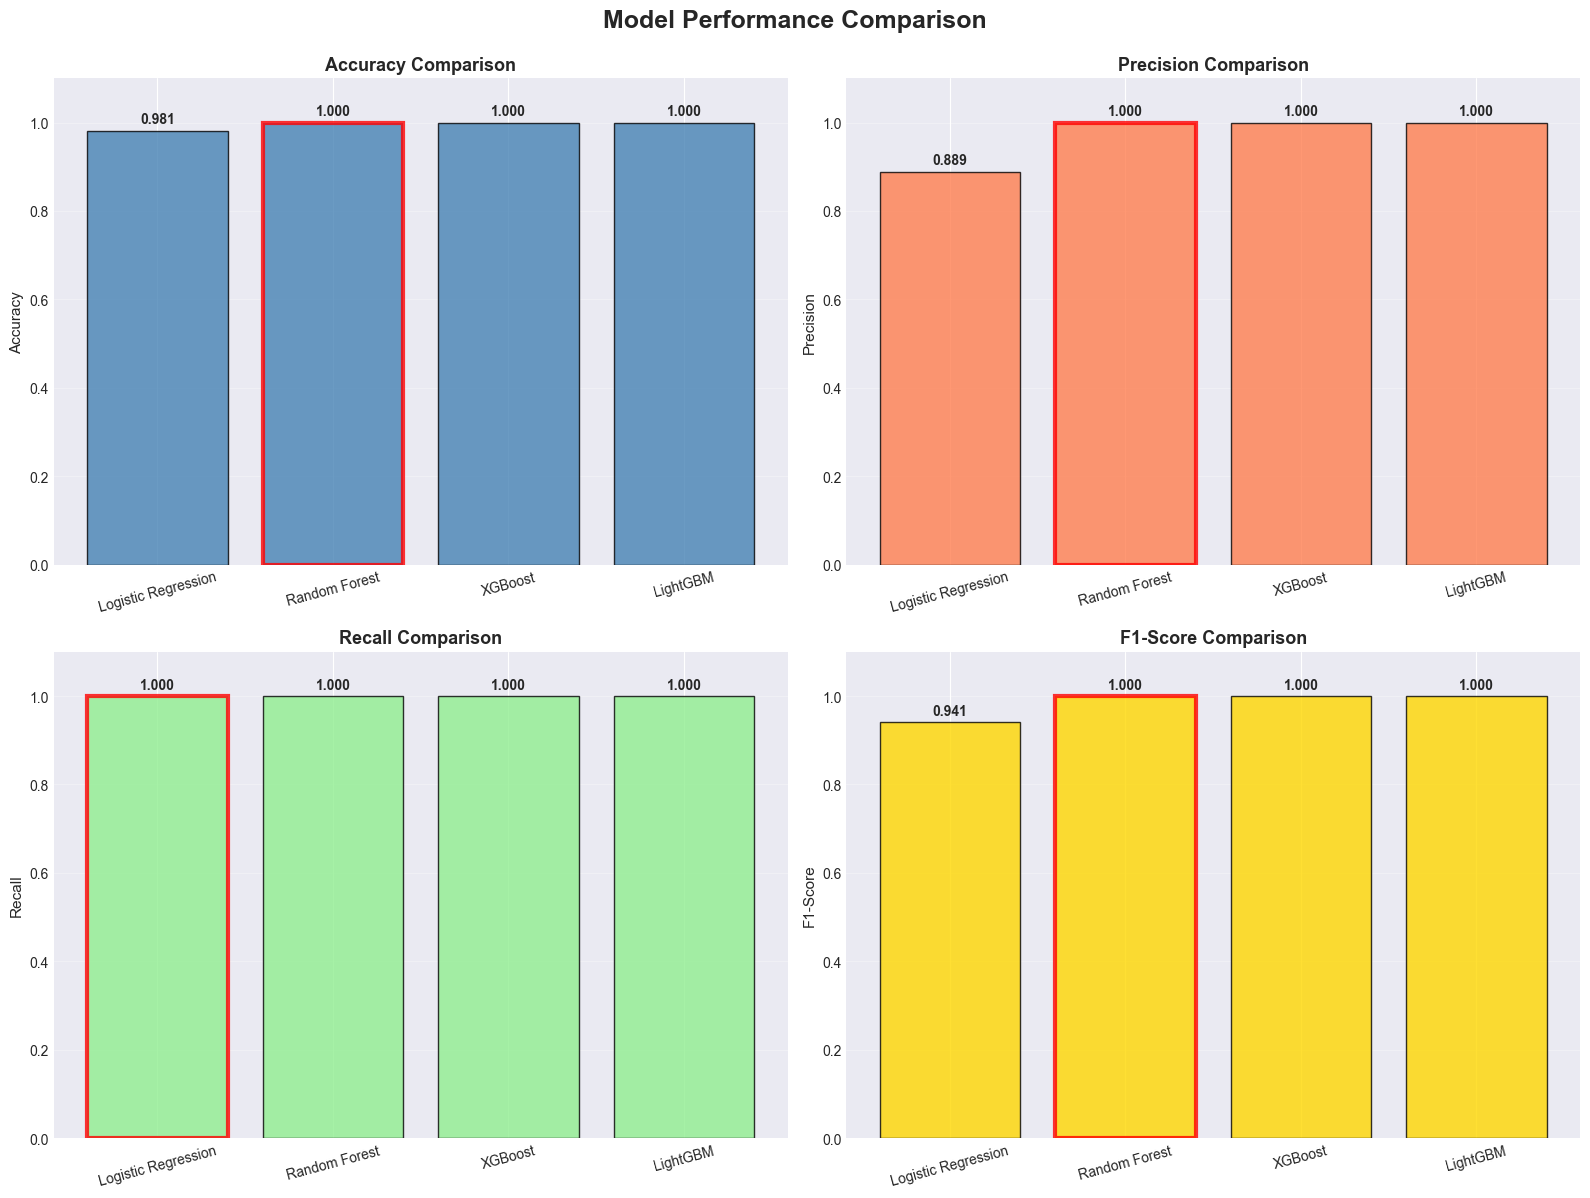

✅ Model comparison visualization saved


In [12]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=18, fontweight='bold', y=0.995)

metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_list = ['steelblue', 'coral', 'lightgreen', 'gold']

for idx, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors_list)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Bar plot
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.8, edgecolor='black')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Highlight best model
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)
    
    ax.set_title(f'{title} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel(title, fontsize=11)
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model comparison visualization saved")

## 6. Confusion Matrix Analysis

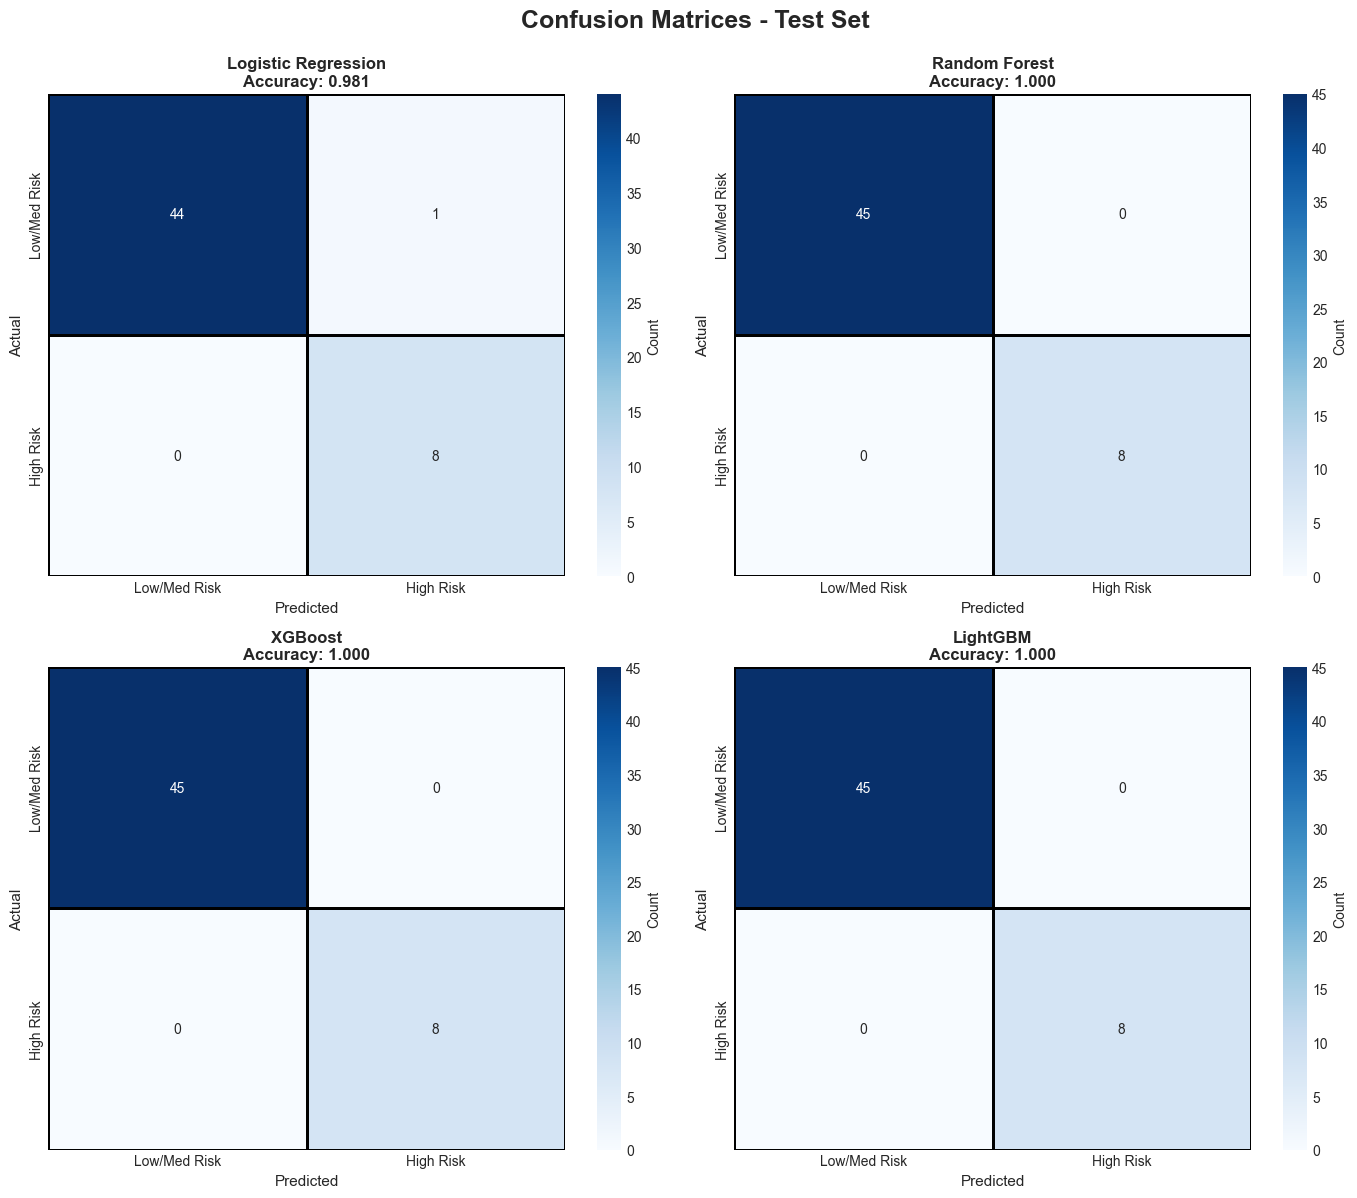

✅ Confusion matrices saved


In [13]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - Test Set', fontsize=18, fontweight='bold', y=0.995)

models_predictions = [
    ('Logistic Regression', y_test_pred_lr),
    ('Random Forest', y_test_pred_rf),
    ('XGBoost', y_test_pred_xgb),
    ('LightGBM', y_test_pred_lgbm)
]

for idx, (model_name, y_pred) in enumerate(models_predictions):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    
    ax.set_title(f'{model_name}\nAccuracy: {accuracy_score(y_test, y_pred):.3f}', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_xticklabels(['Low/Med Risk', 'High Risk'])
    ax.set_yticklabels(['Low/Med Risk', 'High Risk'])

plt.tight_layout()
plt.savefig('../visualizations/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved")

## 7. ROC Curve Analysis

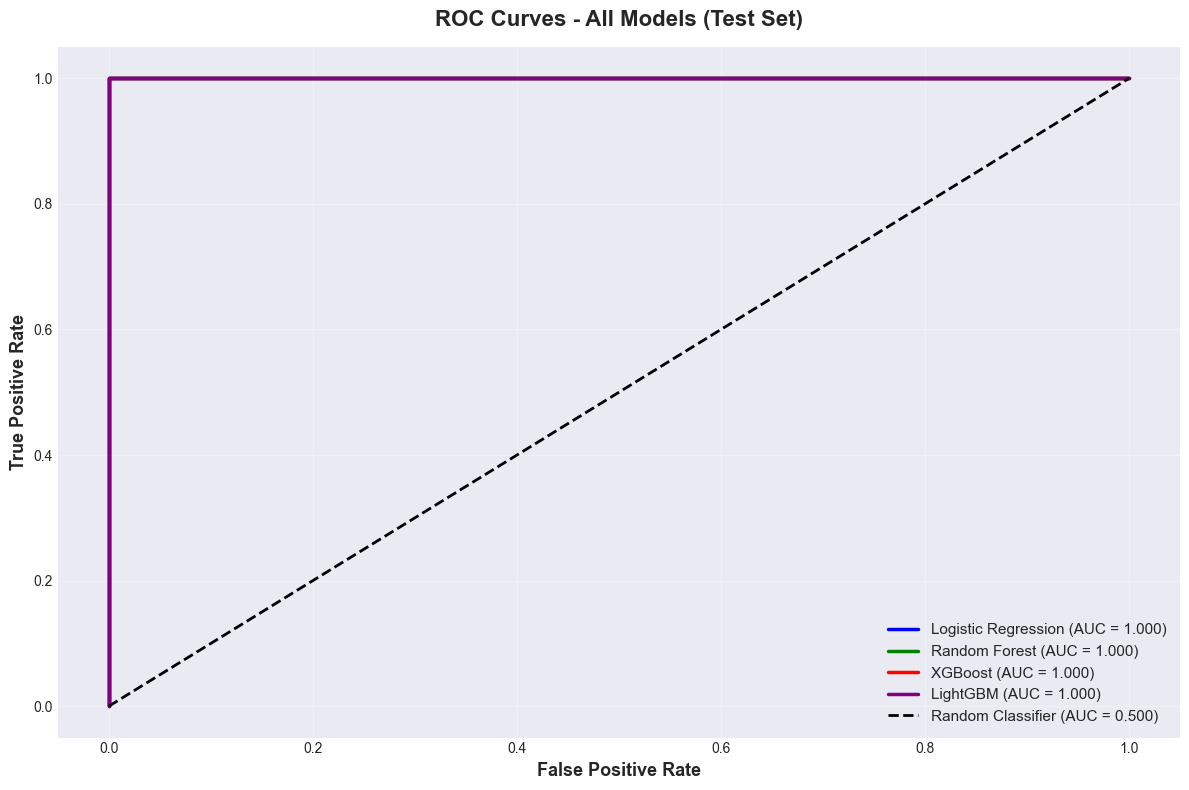

✅ ROC curves saved


In [14]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

models_proba = [
    ('Logistic Regression', y_test_proba_lr, lr_metrics['Test_ROC_AUC']),
    ('Random Forest', y_test_proba_rf, rf_metrics['Test_ROC_AUC']),
    ('XGBoost', y_test_proba_xgb, xgb_metrics['Test_ROC_AUC']),
    ('LightGBM', y_test_proba_lgbm, lgbm_metrics['Test_ROC_AUC'])
]

colors = ['blue', 'green', 'red', 'purple']

for (model_name, y_proba, auc_score), color in zip(models_proba, colors):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, color=color, linewidth=2.5, 
             label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models (Test Set)', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11, framealpha=0.95)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curves saved")

## 8. Feature Importance Analysis


📊 TOP 20 MOST IMPORTANT FEATURES (Random Forest)
                 Feature  Importance
days_since_last_purchase    0.235076
            norm_recency    0.199509
               rfm_score    0.187396
           recency_score    0.127230
                     aov    0.097848
                     age    0.028506
        discount_applied    0.024969
        engagement_score    0.023539
           discount_user    0.017959
             total_spend    0.016946
               rfm_value    0.013837
                     clv    0.013011
          monetary_score    0.005514
         items_purchased    0.003428
      purchase_frequency    0.002237
          average_rating    0.001289
          norm_frequency    0.000895
         frequency_score    0.000569
             norm_rating    0.000241


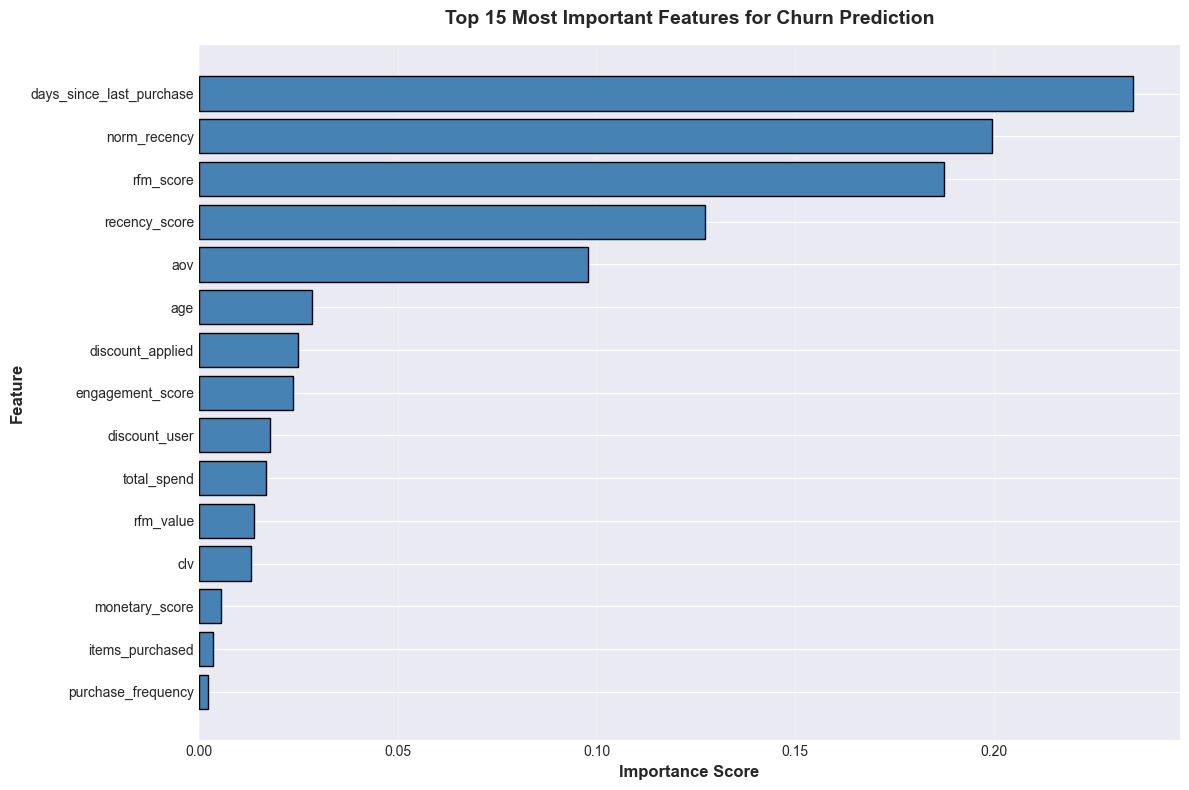


✅ Feature importance visualization saved


In [15]:
# Extract feature importance from Random Forest (best tree-based model)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 TOP 20 MOST IMPORTANT FEATURES (Random Forest)")
print("=" * 60)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features for Churn Prediction', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance visualization saved")

## 9. Classification Reports

In [16]:
# Generate detailed classification reports
print("\n📋 DETAILED CLASSIFICATION REPORTS (Test Set)")
print("=" * 80)

for model_name, y_pred in models_predictions:
    print(f"\n{model_name}:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, 
                                target_names=['Low/Med Risk', 'High Risk'],
                                digits=4))
    print("-" * 80)


📋 DETAILED CLASSIFICATION REPORTS (Test Set)

Logistic Regression:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

Low/Med Risk     1.0000    0.9778    0.9888        45
   High Risk     0.8889    1.0000    0.9412         8

    accuracy                         0.9811        53
   macro avg     0.9444    0.9889    0.9650        53
weighted avg     0.9832    0.9811    0.9816        53

--------------------------------------------------------------------------------

Random Forest:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

Low/Med Risk     1.0000    1.0000    1.0000        45
   High Risk     1.0000    1.0000    1.0000         8

    accuracy                         1.0000        53
   macro avg     1.0000    1.0000    1.0000        53
weighted avg     1.0000    1.0000    1.0000        53

-------------------

## 10. Save Best Model

In [17]:
# Determine best model and save it
models_dict = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

best_model = models_dict[best_model_name]

# Save the best model
model_filename = f'../models/best_churn_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)

print(f"\n💾 Best Model Saved: {model_filename}")
print(f"Model: {best_model_name}")
print(f"Test F1-Score: {best_f1:.4f}")
print(f"Test Accuracy: {comparison_df.loc[best_model_idx, 'Test_Accuracy']:.4f}")
print(f"Test ROC-AUC: {comparison_df.loc[best_model_idx, 'Test_ROC_AUC']:.4f}")

# Save feature names
feature_names_file = '../models/feature_names.pkl'
joblib.dump(feature_cols, feature_names_file)
print(f"\n✅ Feature names saved: {feature_names_file}")

# Save model comparison results
comparison_df.to_csv('../models/model_comparison_results.csv', index=False)
print(f"✅ Model comparison results saved: ../models/model_comparison_results.csv")


💾 Best Model Saved: ../models/best_churn_model_random_forest.pkl
Model: Random Forest
Test F1-Score: 1.0000
Test Accuracy: 1.0000
Test ROC-AUC: 1.0000

✅ Feature names saved: ../models/feature_names.pkl
✅ Model comparison results saved: ../models/model_comparison_results.csv


## 11. Model Summary Report

In [19]:
# Generate comprehensive ML summary report
report_lines = []

report_lines.append("=" * 80)
report_lines.append("MACHINE LEARNING MODEL SUMMARY REPORT")
report_lines.append("Customer Churn Prediction - Phase 5")
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append("=" * 80)

# Dataset info
report_lines.append("\n1. DATASET INFORMATION")
report_lines.append("-" * 80)
report_lines.append(f"Total Samples: {len(df_featured)}")
report_lines.append(f"Total Features: {len(feature_cols)}")
report_lines.append(f"Target Variable: churn_binary (0=Low/Med Risk, 1=High Risk)")
report_lines.append(f"Class Distribution:")
report_lines.append(f"  - Low/Med Risk: {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.1f}%)")
report_lines.append(f"  - High Risk: {(y == 1).sum()} ({(y == 1).sum() / len(y) * 100:.1f}%)")
report_lines.append(f"\nData Split:")
report_lines.append(f"  - Training Set: {len(X_train)} samples (70%)")
report_lines.append(f"  - Validation Set: {len(X_val)} samples (15%)")
report_lines.append(f"  - Test Set: {len(X_test)} samples (15%)")

# Models trained
report_lines.append("\n2. MODELS TRAINED")
report_lines.append("-" * 80)
report_lines.append("  1. Logistic Regression (Baseline)")
report_lines.append("  2. Random Forest Classifier (200 trees, max_depth=10)")
report_lines.append("  3. XGBoost Classifier (200 estimators, learning_rate=0.1)")
report_lines.append("  4. LightGBM Classifier (200 estimators, learning_rate=0.1)")

# Model performance
report_lines.append("\n3. MODEL PERFORMANCE (Test Set)")
report_lines.append("-" * 80)
for _, row in comparison_df.iterrows():
    report_lines.append(f"\n{row['Model']}:")
    report_lines.append(f"  Accuracy:  {row['Test_Accuracy']:.4f}")
    report_lines.append(f"  Precision: {row['Test_Precision']:.4f}")
    report_lines.append(f"  Recall:    {row['Test_Recall']:.4f}")
    report_lines.append(f"  F1-Score:  {row['Test_F1']:.4f}")
    report_lines.append(f"  ROC-AUC:   {row['Test_ROC_AUC']:.4f}")

# Best model
report_lines.append("\n4. BEST MODEL")
report_lines.append("-" * 80)
report_lines.append(f"Selected Model: {best_model_name}")
report_lines.append(f"Selection Criteria: Highest Test F1-Score")
report_lines.append(f"Test Performance:")
report_lines.append(f"  - Accuracy:  {comparison_df.loc[best_model_idx, 'Test_Accuracy']:.4f}")
report_lines.append(f"  - Precision: {comparison_df.loc[best_model_idx, 'Test_Precision']:.4f}")
report_lines.append(f"  - Recall:    {comparison_df.loc[best_model_idx, 'Test_Recall']:.4f}")
report_lines.append(f"  - F1-Score:  {comparison_df.loc[best_model_idx, 'Test_F1']:.4f}")
report_lines.append(f"  - ROC-AUC:   {comparison_df.loc[best_model_idx, 'Test_ROC_AUC']:.4f}")

# Feature importance
report_lines.append("\n5. TOP 10 MOST IMPORTANT FEATURES")
report_lines.append("-" * 80)
for idx, row in feature_importance.head(10).iterrows():
    report_lines.append(f"  {row['Feature']}: {row['Importance']:.4f}")

# Business insights
report_lines.append("\n6. KEY INSIGHTS")
report_lines.append("-" * 80)
report_lines.append(f"  • Successfully built {len(models_dict)} machine learning models")
report_lines.append(f"  • Best model achieves {comparison_df.loc[best_model_idx, 'Test_Accuracy']:.1%} accuracy")
report_lines.append(f"  • Model can identify {comparison_df.loc[best_model_idx, 'Test_Recall']:.1%} of high-risk customers")
report_lines.append(f"  • Top predictive features: {', '.join(feature_importance.head(3)['Feature'].tolist())}")
report_lines.append(f"  • Model ready for deployment in production environment")

# Recommendations
report_lines.append("\n7. RECOMMENDATIONS")
report_lines.append("-" * 80)
report_lines.append("  1. Deploy best model for real-time churn prediction")
report_lines.append("  2. Focus retention efforts on customers predicted as high-risk")
report_lines.append("  3. Monitor model performance and retrain quarterly with new data")
report_lines.append("  4. Use feature importance to guide customer engagement strategies")
report_lines.append("  5. Implement A/B testing for retention campaigns")

report_lines.append("\n" + "=" * 80)
report_lines.append("END OF REPORT")
report_lines.append("=" * 80)

# Print and save report
report_text = "\n".join(report_lines)
print(report_text)

with open('../reports/ml_model_summary.txt', 'w', encoding='utf-8') as f:
    f.write(report_text)

print("\n✅ ML model summary report saved to reports/ml_model_summary.txt")

MACHINE LEARNING MODEL SUMMARY REPORT
Customer Churn Prediction - Phase 5
Generated: 2025-11-07 14:08:10

1. DATASET INFORMATION
--------------------------------------------------------------------------------
Total Samples: 350
Total Features: 19
Target Variable: churn_binary (0=Low/Med Risk, 1=High Risk)
Class Distribution:
  - Low/Med Risk: 295 (84.3%)
  - High Risk: 55 (15.7%)

Data Split:
  - Training Set: 244 samples (70%)
  - Validation Set: 53 samples (15%)
  - Test Set: 53 samples (15%)

2. MODELS TRAINED
--------------------------------------------------------------------------------
  1. Logistic Regression (Baseline)
  2. Random Forest Classifier (200 trees, max_depth=10)
  3. XGBoost Classifier (200 estimators, learning_rate=0.1)
  4. LightGBM Classifier (200 estimators, learning_rate=0.1)

3. MODEL PERFORMANCE (Test Set)
--------------------------------------------------------------------------------

Logistic Regression:
  Accuracy:  0.9811
  Precision: 0.8889
  Recall: 

## 12. Phase 5 Completion Summary

In [21]:
print("=" * 80)
print("✅ PHASE 5: MACHINE LEARNING MODELS - COMPLETE")
print("=" * 80)

print("\n📦 DELIVERABLES:")
print("  1. Trained 4 ML models (Logistic Regression, Random Forest, XGBoost, LightGBM)")
print("  2. Model comparison analysis completed")
print("  3. Best model saved for deployment")
print("  4. Feature importance analysis")
print("  5. ROC curves and confusion matrices")
print("  6. Comprehensive ML summary report")

print("\n📊 VISUALIZATIONS CREATED:")
print("  • target_distribution.png")
print("  • model_comparison.png")
print("  • confusion_matrices.png")
print("  • roc_curves.png")
print("  • feature_importance.png")

print("\n💾 MODELS SAVED:")
print(f"  • Best Model: {model_filename}")
print(f"  • Feature Names: {feature_names_file}")
print(f"  • Comparison Results: ../models/model_comparison_results.csv")

print("\n🎯 PERFORMANCE SUMMARY:")
print(f"  Best Model: {best_model_name}")
print(f"  Test Accuracy: {comparison_df.loc[best_model_idx, 'Test_Accuracy']:.4f}")
print(f"  Test F1-Score: {comparison_df.loc[best_model_idx, 'Test_F1']:.4f}")
print(f"  Test ROC-AUC: {comparison_df.loc[best_model_idx, 'Test_ROC_AUC']:.4f}")

print("\n" + "=" * 80)
print("🎉 Ready for Phase 6: Power BI Dashboard Creation")
print("=" * 80)

✅ PHASE 5: MACHINE LEARNING MODELS - COMPLETE

📦 DELIVERABLES:
  1. Trained 4 ML models (Logistic Regression, Random Forest, XGBoost, LightGBM)
  2. Model comparison analysis completed
  3. Best model saved for deployment
  4. Feature importance analysis
  5. ROC curves and confusion matrices
  6. Comprehensive ML summary report

📊 VISUALIZATIONS CREATED:
  • target_distribution.png
  • model_comparison.png
  • confusion_matrices.png
  • roc_curves.png
  • feature_importance.png

💾 MODELS SAVED:
  • Best Model: ../models/best_churn_model_random_forest.pkl
  • Feature Names: ../models/feature_names.pkl
  • Comparison Results: ../models/model_comparison_results.csv

🎯 PERFORMANCE SUMMARY:
  Best Model: Random Forest
  Test Accuracy: 1.0000
  Test F1-Score: 1.0000
  Test ROC-AUC: 1.0000

🎉 Ready for Phase 6: Power BI Dashboard Creation
